In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import scipy.io as io

In [2]:
from PIL import Image
import zipfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
f=zipfile.ZipFile('./Images.zip','r')
for file in f.namelist():
    f.extract(file) #解压到的位置，./表示当前目录(与此.ipynb文件同一个目录)
f.close()

In [54]:
f=zipfile.ZipFile('./label2.zip','r')
for file in f.namelist():
    f.extract(file) #解压到的位置，./表示当前目录(与此.ipynb文件同一个目录)
f.close()

In [6]:
a=io.loadmat('./label/coast_arnat59.mat')

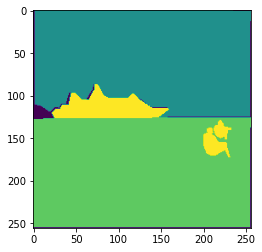

In [9]:
plt.imshow((a['S']+1)*100)

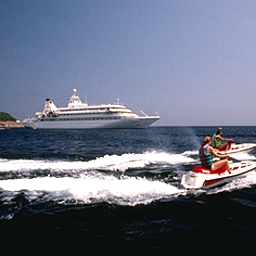

In [12]:
Image.open('./Images/image/coast_arnat59.jpg')

In [36]:
a=tf.constant([1,3,4])

In [62]:
a=tf.zeros([4,5,6])

In [69]:
tf.TensorShape([3,4])

TensorShape([3, 4])

In [74]:
mod=tf.keras.applications.resnet.ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)

In [158]:
model=keras.Sequential()

In [159]:
model.add(keras.layers.Dense(64000,activation='relu'))
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(1,activation='softmax'))

In [160]:
model.build(input_shape=(6,2))

In [161]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (6, 64000)                192000    
_________________________________________________________________
dense_44 (Dense)             (6, 128)                  8192128   
_________________________________________________________________
dense_45 (Dense)             (6, 1)                    129       
Total params: 8,384,257
Trainable params: 8,384,257
Non-trainable params: 0
_________________________________________________________________


In [162]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # 优化函数，设定学习率（lr）等参数  
model.compile(loss='categorical_crossentropy', optimizer=sgd) # 使用交叉熵作为loss函数

In [163]:
model.fit(x=np.array([1,2,3,4,5,6,7,8,9,10,11,21]).reshape(6,2),y=np.array([1,0,1,1,0,1]),epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 996us/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 961us/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 998us/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 998us/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00


In [82]:
tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),activation="relu",input_shape=(28,28,1),padding="valid")

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [47]:
#定义下采样
def down_sample(filters,size,apply_batchnorm=True):
    initializer=tf.random_normal_initializer(0,0.02)
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    if apply_batchnorm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    return block

In [48]:
#定义上采样
def up_sample(filters,size,apply_dropout=False):
    initializer=tf.random_normal_initializer(0,0.02)
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.5))
    block.add(tf.keras.layers.ReLU())
    return block

In [51]:
def Generator():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    initializer=tf.random_normal_initializer(0,0.02)
    last=tf.keras.layers.Conv2DTranspose(3,4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh')
    down_stack=[
        down_sample(64,4,apply_batchnorm=False),
        down_sample(128,4),
        down_sample(256,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
    ]
    
    up_stack=[
        up_sample(512,4,apply_dropout=True),
        up_sample(512,4,apply_dropout=True),
        up_sample(512,4,apply_dropout=True),
        up_sample(512,4),
        up_sample(256,4),
        up_sample(128,4),
        up_sample(64,4),
    ]
    
    x=inputs
    skips=[]
    for down in down_stack:
        x=down(x)
        skips.append(x)
    skips=reversed(skips[:-1])
    for up,skip in zip(up_stack,skips):
        x=up(x)
        x=tf.keras.layers.concatenate([x,skip])
    x=last(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

In [52]:
Generator().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 64, 64, 128)  131584      sequential_16[0][0]              
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 32, 32, 256)  525312      sequential_17[0][0]              
_______________________________________________________________________________________

In [ ]:
lam=100
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def gen